In [2]:
# my vae based on Tsainb conv-vae
from tempfile import NamedTemporaryFile
import matplotlib.animation as animation
from IPython.display import HTML

# Import all of our packages
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import math
from tqdm import tqdm # making loops prettier
import h5py # for reading our dataset
#import ipywidgets as widgets
#from ipywidgets import interact, interactive, fixed
import seaborn as sns
import pandas as pd
from glob import glob
import os
import socket

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib import layers

from tensorflow.python.client import device_lib

import matplotlib
#plt.style.use('seaborn-pastel')
plt.style.use(matplotlib.style.available[19])
#9
#17 -18 - 19
comp_name=socket.gethostname()
%matplotlib inline  

In [2]:
import os
if 'niao' in comp_name:
    gpus = [1]
    os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

# Data load and generate an iterator

In [4]:
# load the synthesis data
import pickle
sweep_file = '/usr/local/experiment/tmp_data/syn_sweeps/spectral_pandas_sweep_002.pickle'

#sweep_file = '/home/earneodo/experiment/tmp_data/syn_sweeps/spectral_pandas_sweep_002.pickle'
df_syn = pd.read_pickle(sweep_file)

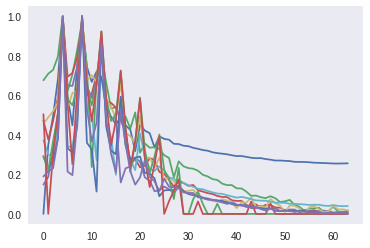

In [5]:
all_spectra = (df_syn['spectral'].as_matrix())
all_spectra_array = np.stack([np.array(s) for s in all_spectra], axis=0)

# subsample the frequencies to go to dimension 64
all_spectra_array = all_spectra_array[:,::2][:,:64]

all_label_array = np.array([df_syn['a'], df_syn['b']]).T

plt.plot(all_spectra_array[:10, :].T);
df_syn['spectral'] = all_spectra_array.tolist()

(160000, 5)


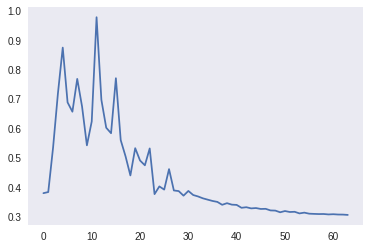

In [6]:
# a batch generator using pandas

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u + u_min)/u_range

class PdBatcher(object):
    def __init__(self, data_frame, 
                 x_field=None, 
                 y_field=None, 
                 train_fraction=0.9,
                 batch_size=50):
        
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
        self.current = 0
        self._batch_size = batch_size
    
    def __iter__(self):
        return self
      
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:300] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch
    
# a batch generator using pandas
class SynBatcher(PdBatcher):
    def __init__(self, data_frame, x_field=None, y_field=None, train_factor=0.9, batch_size=50):
    
        PdBatcher.__init__(self, data_frame, 
              x_field=x_field, y_field=y_field, train_fraction=train_factor, batch_size=batch_size)
       
    def _make_train_array(self):
        all_spectra = (np.array(self.train_frame['spectral'].as_matrix()))
        self.all_train_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.train_label_array = np.array([self.train_frame['a'], self.train_frame['b']]).T
        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.test_label_array = np.array([self.test_frame['a'], self.test_frame['b']]).T

    def train_batch(self):
        n = self._batch_size
        idx = np.random.randint(0, self.all_train_array.shape[0], n).tolist()
        return [self.all_train_array[idx], self.train_label_array[idx]]
    
    def test_batch(self):
        n = self._batch_size
        idx = np.random.randint(0, self.all_test_array.shape[0], n).tolist()
        return [self.all_test_array[idx], self.test_label_array[idx]]
    
    def __next__(self):
        self.current +=1
        return self.train_batch()

#pdb = PdBatcher(df.loc[df['bird'].isin(['z007', 'z020', 'z017'])])

pdb = SynBatcher(df_syn, batch_size=50)
print(df_syn.shape)

x, y = pdb.train_batch()
num_examples = pdb.all_train_array.shape[0]

plt.plot(x[10])

## Parameters (globals for now)

In [7]:
# Network:
nw_par = {'dim_1': 64, #frequency bins
         'dim_2': 1, # time_steps of the slice (for spectrograms it is time)
         'dim_3': 1, #pow value
         'batch_size': 32,
         'hidden_size': 2,
         'num_examples': 0, #examples in the data set,
         'num_epochs': 100}

# globals, for now
dim1 = 64
dim2 = 1
dim3 = 1
batch_size = 32
hidden_size = 40
num_epochs = 30
num_examples = 0

# Remake the batcher
pdb = SynBatcher(df_syn, batch_size=batch_size)
num_examples = pdb.all_train_array.shape[0]

### Which GPUs are we using?
- Set `gpus` to a list of the GPUs you're using. The network will then split up the work between those gpus

In [8]:
def list_devices(only_gpu=False):
    dev = device_lib.list_local_devices()
    if only_gpu:
         dev = [d for d in dev if 'gpu' in d.name]
    return dev

dev = list_devices(only_gpu=True)
print(dev)

# mask gpus
gpus = [1] # Here I set CUDA to only see one GPU
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

[name: "/gpu:0"
device_type: "GPU"
memory_limit: 269090816
locality {
  bus_id: 1
}
incarnation: 5983552223939240436
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:02:00.0"
]


### The definitios of the network
- encoder
- generator (decoder)

* Functions:
    - inference

In [9]:
def encoder(X):
    '''Create encoder network.
    Args:
        x: a batch of flattened images [batch_size, 28*28]
    Returns:
        A tensor that expresses the encoder network
            # The transformation is parametrized and can be learned.
            # returns network output, mean, setd
    '''
    net = tf.reshape(X, [batch_size, dim1, dim2, dim3])
    net = layers.conv2d(net, dim1, [3, 1], stride=2)
    net = layers.conv2d(net, dim1*2, [3, 1], stride=2)
    net = layers.conv2d(net, dim1*4, [3, 1], stride=2)
    net = layers.conv2d(net, dim1*8, [3, 1], stride=2)
    net = layers.flatten(net)
    net = layers.fully_connected(net, dim1*dim1*2)
    net = layers.fully_connected(net, dim1*dim1*2)
    net = layers.fully_connected(net, hidden_size, activation_fn=None)
    #print('Encoder shapes: ', shape(net), shape(l1), shape(l2), shape(l3), shape(l4))
    return net

def generator(Z):
    '''Create generator network.
        If input tensor is provided then decodes it, otherwise samples from 
        a sampled vector.
    Args:
        x: a batch of vectors to decode
    Returns:
        A tensor that expresses the generator network
    '''
    net = layers.fully_connected(Z,  dim1*dim1*2)
    net = layers.fully_connected(net,  dim1*dim1*2)
    net = tf.reshape(layers.fully_connected(net, 4*1*dim1*8), [batch_size, 4,1,dim1*8])
    
    net = tf.image.resize_nearest_neighbor(net, (dim1*8, 1))
    net = layers.conv2d(net, dim1*8, [3, 1], stride=1)
    
    net = tf.image.resize_nearest_neighbor(net, (dim1*4, 1))
    net = layers.conv2d(net, dim1*4, [3, 1], stride=1)
    
    net = tf.image.resize_nearest_neighbor(net, (dim1*2, 1))
    net = layers.conv2d(net, dim1*2, [3, 1], stride=1)
    
    net = tf.image.resize_nearest_neighbor(net, (dim1, 1))
    net = layers.conv2d(net, dim1, [3, 1], stride=1)
   
    net = layers.conv2d(net, dim3, 1, stride=1, activation_fn=tf.sigmoid)
    net = layers.flatten(net)
    
    #print('Decoder shapes: ', (shape(l1), shape(l2), shape(l3), shape(l4), shape(l5a)))
    return net #l1,l2,l3,l5a

def inference(x):
    """
    Run the models. Called inference because it does the same thing as tensorflow's cifar tutorial
    """
    z_p =  tf.random_normal((batch_size, hidden_size), 0, 0.1) # normal dist for GAN

    with arg_scope([layers.fully_connected, layers.conv2d], activation_fn=tf.nn.relu):
        
        with tf.variable_scope("enc"):         
                z_x = encoder(x) # get z from the input      
        with tf.variable_scope("gen"):
            x_tilde = generator(z_x) 
            
    return z_x, x_tilde

### Loss - define our various loss functions
- **SSE** - we don't actually use this loss (also its the MSE), its just to see how close x is to x_tilde
- **KL Loss** - our VAE gaussian distribution loss. 
  - See https://arxiv.org/abs/1312.6114
- **D_loss** - Our descriminator loss, how good the discriminator is at telling if something is real
- **G_loss** - essentially the opposite of the D_loss, how good the generator is a tricking the discriminator
- ***notice we clip our values to make sure learning rates don't explode***

In [10]:
def squared_dist(A): 
    #http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
    distances = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)
    return distances


def loss(x, x_tilde, z_x):
    """
    Loss functions for SSE, KL divergence, Discrim, Generator, Lth Layer Similarity
    """
    # an esoteric loss from a vae/gan hybrid https://jmetzen.github.io/2015-11-27/vae.html
#     reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_tilde)
#                               + (1. - x) * tf.log(1e-10 + 1. - x_tilde),
#                               1)
    ### We don't actually use SSE (MSE) loss for anything (but maybe pretraining)
    SSE_loss = tf.reduce_mean(tf.square(x - x_tilde)) # This is what a normal VAE uses
    #sdx = squared_dist(x)
    #sdx = sdx/tf.reduce_mean(sdx)
    #sdz = squared_dist(z_x)
    #sdz = sdz/tf.reduce_mean(sdz)
    #distance_loss =  tf.reduce_mean(tf.square(tf.log(tf.constant(1.)+sdx) - (tf.log(tf.constant(1.)+sdz))))

    return  SSE_loss#, distance_loss

### Average the gradients between towers
- This function is taken directly from 
    - https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10_multi_gpu_train.py
- Basically we're taking a list of gradients from each tower, and averaging them together

In [11]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
     
    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

### Plot network output
- This is just my ugly function to regularly plot the output of my network - tensorboard would probably be a better option for this

In [12]:
graph = tf.Graph()

### With your graph, define what a step is (needed for multi-gpu), and what your optimizers are for each of your networks

In [13]:
with graph.as_default():
    #with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to count number of train calls
    global_step = tf.get_variable(
        'global_step', [],
        initializer=tf.constant_initializer(0), trainable=False)

    # different optimizers are needed for different learning rates (using the same learning rate seems to work fine though)
    lr_G = tf.placeholder(tf.float32, shape=[])
    lr_E = tf.placeholder(tf.float32, shape=[])
    opt_G = tf.train.AdamOptimizer(lr_G, epsilon=1.0)
    opt_E = tf.train.AdamOptimizer(lr_E, epsilon=1.0)

### Run all of the functions we defined above
- `tower_grads_e` defines the list of gradients for the encoder for each tower
- For each GPU we grab parameters corresponding to each network, we then calculate the gradients, and add them to the twoers to be averaged


In [14]:
with graph.as_default():

    # These are the lists of gradients for each tower 
    tower_grads_e = []
    tower_grads_g = []

    all_input = tf.placeholder(tf.float32, [batch_size*num_gpus, dim1*dim2*dim3])
    E_param = tf.placeholder(tf.float32)
    G_param = tf.placeholder(tf.float32)
    #dist_param = tf.placeholder(tf.float32)

    with tf.variable_scope(tf.get_variable_scope()):
        # Define the network for each GPU
        for i, n_gpu in enumerate(gpus):
              with tf.device('/gpu:%d' % n_gpu):
                    with tf.name_scope('Tower_%d' % (i)) as scope:
                        # grab this portion of the input
                        next_batch = all_input[i*batch_size:(i+1)*batch_size,:]

                        # Construct the model
                        z_x, x_tilde = inference(next_batch)

                        # Calculate the loss for this tower   
                        batch_loss = loss(next_batch, x_tilde, z_x)

                        # specify loss to parameters
                        params = tf.trainable_variables()
                        E_params = [i for i in params if 'enc' in i.name]
                        G_params = [i for i in params if 'gen' in i.name]

                        # Calculate the losses specific to encoder, generator, decoder
                        L_e = tf.clip_by_value(E_param*batch_loss, -100, 100)
                        L_g = tf.clip_by_value(G_param*batch_loss, -100, 100)

                        # Reuse variables for the next tower.
                        tf.get_variable_scope().reuse_variables()

                        # Calculate the gradients for the batch of data on this CIFAR tower.
                        grads_e = opt_E.compute_gradients(L_e, var_list = E_params)
                        grads_g = opt_G.compute_gradients(L_g, var_list = G_params)

                        # Keep track of the gradients across all towers.
                        tower_grads_e.append(grads_e)
                        tower_grads_g.append(grads_g)

### Now lets average, and apply those gradients


In [15]:
with graph.as_default():
    # Average the gradients
    grads_e = average_gradients(tower_grads_e)
    grads_g = average_gradients(tower_grads_g)

    # apply the gradients with our optimizers
    train_E = opt_E.apply_gradients(grads_e, global_step=global_step)
    train_G = opt_G.apply_gradients(grads_g, global_step=global_step)

### Now lets actually run our session

In [16]:
with graph.as_default():
    # Start the Session
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession(graph=graph,config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    sess.run(init)
    saver = tf.train.Saver() # initialize network saver

ResourceExhaustedError: OOM when allocating tensor of shape [8192,8192] and type float
	 [[Node: enc/fully_connected_1/weights/Adam/Initializer/zeros = Const[_class=["loc:@enc/fully_connected_1/weights"], dtype=DT_FLOAT, value=Tensor<type: float shape: [8192,8192] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'enc/fully_connected_1/weights/Adam/Initializer/zeros', defined at:
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-d258f3305910>", line 7, in <module>
    train_E = opt_E.apply_gradients(grads_e, global_step=global_step)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/adam.py", line 128, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 278, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1383, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [8192,8192] and type float
	 [[Node: enc/fully_connected_1/weights/Adam/Initializer/zeros = Const[_class=["loc:@enc/fully_connected_1/weights"], dtype=DT_FLOAT, value=Tensor<type: float shape: [8192,8192] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### Get some example data to do visualizations with

In [ ]:
total_batch = int(np.floor(num_examples / batch_size/num_gpus)) # how many batches are in an epoch
total_batch

In [ ]:
def plot_reconstruction(x_sample):
    recon_x = sess.run((x_tilde), {all_input: x_sample})
    x_reconstruct = np.squeeze(recon_x)

    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        plt.plot(x_sample[i])
        plt.title("Test input")
        plt.subplot(5, 2, 2*i + 2)
        plt.plot(x_reconstruct[i])
        plt.title("Reconstruction")
    plt.tight_layout()

In [ ]:
%matplotlib inline
total_batch = int(np.floor(num_examples / batch_size/num_gpus)) # how many batches are in an epoch

# We balance of generator and discriminators learning rate by using a sigmoid function,
#  encouraging the generator and discriminator be about equal

SSE_loss_list = []
dist_loss_list = []
epoch = 0

while epoch < 10: 
   
    e_current_lr = 1.0
    g_current_lr = 1.0

    for i in tqdm(range(total_batch)):
        # balence gen and descrim  
        next_batches, _ = pdb.train_batch()

        _, _,SSE_err = sess.run([
                train_E, train_G,
                batch_loss, #SSE_loss, distance_loss
            ],
                                        {
                all_input: next_batches,
                G_param: 1.,
                E_param: 1.,
                #dist_param: 0.0,#1.0e-1,
                lr_E: e_current_lr,
                lr_G: g_current_lr
            }
       )
        print(SSE_err)
        SSE_loss_list.append(SSE_err)    
        #dist_loss_list.append(dist_err)    
        if i%1000 == 0:
            # print display network output
            IPython.display.clear_output()
            print('Epoch: '+str(epoch))
            plot_reconstruction(pdb.train_batch()[0])

    # save network
    #if epoch%10 == 0:
    #saver.save(sess,''.join(['models/birdsong_mel32',str(epoch).zfill(4),'.tfmod']))
    epoch +=1

In [ ]:
# compress-reconstruct one batch
x_sample, _ = pdb.train_batch()

recon_x = sess.run((x_tilde), {all_input: x_sample})
x_reconstruct = np.squeeze(recon_x)

for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()


In [ ]:
# compress-reconstruct one batch
x_sample, _ = pdb.test_batch()

def plot_reconstruction(x_sample):
    recon_x = sess.run((x_tilde), {all_input: x_sample})
    x_reconstruct = np.squeeze(recon_x)

    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        plt.plot(x_sample[i])
        plt.title("Test input")
        plt.subplot(5, 2, 2*i + 2)
        plt.plot(x_reconstruct[i])
        plt.title("Reconstruction")
    plt.tight_layout()
    
plot_reconstruction(pdb.test_batch()[0])


In [ ]:
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()